In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imbikramsaha/caltech-101")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/caltech-101


In [2]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input/caltech-101")
print(list(DATA_DIR.iterdir())[:10])  # Peek categories

[PosixPath('/kaggle/input/caltech-101/caltech-101')]


In [3]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input/caltech-101/caltech-101")
print(list(DATA_DIR.iterdir())[:10])  # Now should show category folders

[PosixPath('/kaggle/input/caltech-101/caltech-101/scorpion'), PosixPath('/kaggle/input/caltech-101/caltech-101/hedgehog'), PosixPath('/kaggle/input/caltech-101/caltech-101/crocodile_head'), PosixPath('/kaggle/input/caltech-101/caltech-101/headphone'), PosixPath('/kaggle/input/caltech-101/caltech-101/mandolin'), PosixPath('/kaggle/input/caltech-101/caltech-101/ewer'), PosixPath('/kaggle/input/caltech-101/caltech-101/stop_sign'), PosixPath('/kaggle/input/caltech-101/caltech-101/ant'), PosixPath('/kaggle/input/caltech-101/caltech-101/ferry'), PosixPath('/kaggle/input/caltech-101/caltech-101/butterfly')]


In [4]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input/caltech-101/caltech-101")
OUT_DIR  = Path("/kaggle/working/results")
IMG_DIR  = OUT_DIR / "images"
FIG_DIR  = OUT_DIR / "figures"

for d in [OUT_DIR, IMG_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Found categories:", len([p for p in DATA_DIR.iterdir() if p.is_dir()]))

Found categories: 102


In [5]:
import random, shutil

SUBSET_DIR = Path("/kaggle/working/caltech101_subset")
SUBSET_DIR.mkdir(parents=True, exist_ok=True)

categories = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])
random.seed(42)

pick_cats = random.sample(categories, k=min(10, len(categories)))
for cat in pick_cats:
    dst = SUBSET_DIR / cat.name
    dst.mkdir(exist_ok=True)
    jpgs = list(cat.glob("*.jpg")) + list(cat.glob("*.jpeg")) + list(cat.glob("*.png"))
    for f in random.sample(jpgs, k=min(50, len(jpgs))):
        shutil.copy(f, dst)

print("Subset categories:", [c.name for c in pick_cats])

Subset categories: ['scissors', 'brain', 'Leopards', 'umbrella', 'dragonfly', 'cup', 'crayfish', 'butterfly', 'bonsai', 'stapler']


In [6]:
%%writefile robust_test.py
import argparse, sys, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim, mean_squared_error, peak_signal_noise_ratio as psnr
from skimage.filters import sobel
import matplotlib
matplotlib.use("Agg")  # safe in headless environments
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True)

def load_img_u8(path: Path, resize: int|None=None) -> np.ndarray:
    img = Image.open(path).convert("L")
    if resize is not None and resize > 0:
        img = img.resize((resize, resize), Image.BICUBIC)
    return np.array(img, dtype=np.uint8)

def to_pil(arr: np.ndarray) -> Image.Image:
    return Image.fromarray(arr.astype(np.uint8), mode="L")

# ── transforms ──
def tf_jpeg(x: np.ndarray, quality: int) -> np.ndarray:
    from io import BytesIO
    img = to_pil(x)
    buf = BytesIO()
    img.save(buf, format="JPEG", quality=int(quality))
    buf.seek(0)
    out = Image.open(buf).convert("L")
    return np.array(out, dtype=np.uint8)

def tf_crop(x: np.ndarray, frac: float) -> np.ndarray:
    h, w = x.shape
    df = max(0.0, min(float(frac), 0.45))
    ch, cw = int(h*(1-2*df)), int(w*(1-2*df))
    y0, x0 = (h-ch)//2, (w-cw)//2
    cropped = x[y0:y0+ch, x0:x0+cw]
    out = Image.fromarray(cropped).resize((w, h), Image.BICUBIC)
    return np.array(out, dtype=np.uint8)

def tf_rotate(x: np.ndarray, degrees: float) -> np.ndarray:
    img = to_pil(x)
    try:
        rot = img.rotate(float(degrees), resample=Image.BICUBIC, expand=False, fillcolor=0)
    except TypeError:
        rot = img.rotate(float(degrees), resample=Image.BICUBIC, expand=False)
    return np.array(rot, dtype=np.uint8)

def tf_noise(x: np.ndarray, sigma: float) -> np.ndarray:
    n = np.random.normal(0.0, float(sigma), x.shape)
    y = x.astype(np.float32) + n
    y = np.clip(y, 0, 255).astype(np.uint8)
    return y

def tf_blur(x: np.ndarray, radius: float) -> np.ndarray:
    return np.array(to_pil(x).filter(ImageFilter.GaussianBlur(radius=float(radius))), dtype=np.uint8)

# ── metrics ──
def mse(a,b): return float(mean_squared_error(a,b))
def psnr_db(a,b):
    if np.array_equal(a, b): return 99.0
    return float(psnr(a,b, data_range=255))
def ssim_u8(a,b): return float(ssim(a,b, data_range=255))

def edge_ssim(a,b):
    ea, eb = sobel(a), sobel(b)
    def norm255(z):
        rng = z.max() - z.min()
        if rng < 1e-6: return np.zeros_like(z, dtype=np.uint8)
        return (255*(z - z.min())/rng).astype(np.uint8)
    ea, eb = norm255(ea), norm255(eb)
    return float(ssim(ea, eb, data_range=255))

def panel_before_after(orig, perturbed, save_path: Path, title: str):
    fig = plt.figure(dpi=140)
    plt.suptitle(title)
    plt.subplot(1,2,1); plt.imshow(orig, cmap="gray"); plt.axis("off"); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(perturbed, cmap="gray"); plt.axis("off"); plt.title("Transformed")
    fig.tight_layout()
    fig.savefig(save_path)
    plt.close(fig)

def summarize_and_plot(df: pd.DataFrame, out_dir: Path):
    fig_dir = out_dir / "figures"
    ensure_dir(fig_dir)

    if df.empty:
        print("[WARN] results dataframe is empty; skipping plots.")
        return

    # coerce level to numeric where possible for proper sorting
    def to_num(x):
        try: return float(x)
        except: return np.nan

    df = df.copy()
    df["level_num"] = df["level"].apply(to_num)

    grp = df.groupby(["transform","level"], as_index=False)[["psnr","ssim","edge_ssim","mse"]].mean()
    grp = grp.sort_values(["transform","level"], key=lambda col: (
        grp["level"].apply(to_num) if col.name=="level" else col
    ))
    grp.to_csv(out_dir / "summary_by_transform.csv", index=False)

    saved = []
    for metric in ["psnr","ssim","edge_ssim"]:
        fig = plt.figure(dpi=140)
        for tname, sub in grp.groupby("transform"):
            # Sort by numeric level if available
            try:
                sub = sub.assign(level_num=sub["level"].apply(to_num)).sort_values("level_num")
                xlabels = [str(v) for v in sub["level"]]
                yvals = sub[metric].values
                if len(yvals)==0: 
                    continue
            except Exception as e:
                print(f"[WARN] skipping {tname} on {metric}: {e}")
                continue
            plt.plot(xlabels, yvals, marker="o", label=tname)
        plt.xlabel("Severity level")
        plt.ylabel(metric.upper())
        plt.title(f"Average {metric.upper()} vs Severity")
        plt.legend()
        fig.tight_layout()
        # save in both root and figures/ so downstream code works either way
        root_path = out_dir / f"{metric}_vs_severity.png"
        fig_path  = fig_dir  / f"{metric}_vs_severity.png"
        fig.savefig(root_path)
        fig.savefig(fig_path)
        saved += [root_path, fig_path]
        plt.close(fig)

    print("[INFO] Saved summary and plots:")
    print("  -", out_dir / "summary_by_transform.csv")
    for p in saved:
        print("  -", p)

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--in_dir", type=str, required=True)
    ap.add_argument("--out_dir", type=str, required=True)
    ap.add_argument("--exts", type=str, default=".jpg,.jpeg,.png")
    ap.add_argument("--resize", type=int, default=256, help="square resize; 0 to keep native")
    ap.add_argument("--jpeg",  nargs="*", type=int,   default=[80,60,40,20])
    ap.add_argument("--crop",  nargs="*", type=float, default=[0.05,0.10,0.20])
    ap.add_argument("--rotate",nargs="*", type=float, default=[5,10,20])
    ap.add_argument("--noise", nargs="*", type=float, default=[5,10,20])
    ap.add_argument("--blur",  nargs="*", type=float, default=[1,2,3])
    ap.add_argument("--seed", type=int, default=42)
    args = ap.parse_args()

    np.random.seed(args.seed)
    in_dir = Path(args.in_dir)
    out_dir = Path(args.out_dir); ensure_dir(out_dir)
    img_dir = out_dir / "images"; ensure_dir(img_dir)
    fig_dir = out_dir / "figures"; ensure_dir(fig_dir)

    exts = [e.strip().lower() for e in args.exts.split(",") if e.strip()]
    files = [p for p in in_dir.rglob("*") if p.is_file() and any(str(p).lower().endswith(e) for e in exts)]
    if not files:
        print("No input files found.", file=sys.stderr); sys.exit(1)

    rows = []
    for f in tqdm(files, desc="Processing"):
        try:
            orig = load_img_u8(f, resize=args.resize if args.resize>0 else None)
        except Exception as e:
            print(f"[WARN] skip {f}: {e}", file=sys.stderr); continue

        base = f"{f.stem}"
        def record(tname, level, out_arr):
            row = {
                "file": str(f),
                "transform": tname,
                "level": level,
                "mse": mse(orig, out_arr),
                "psnr": psnr_db(orig, out_arr),
                "ssim": ssim_u8(orig, out_arr),
                "edge_ssim": edge_ssim(orig, out_arr),
            }
            rows.append(row)
            out_name = f"{base}__{tname}_{level}.png"
            to_pil(out_arr).save(img_dir / out_name)
            panel_before_after(orig, out_arr, fig_dir / f"{base}__{tname}_{level}_panel.png",
                               title=f"{tname}={level}")

        for q in args.jpeg:   record("jpeg", q,  tf_jpeg(orig, q))
        for c in args.crop:   record("crop", c,  tf_crop(orig, c))
        for r in args.rotate: record("rotate", r,tf_rotate(orig, r))
        for n in args.noise:  record("noise", n, tf_noise(orig, n))
        for b in args.blur:   record("blur", b,  tf_blur(orig, b))

    df = pd.DataFrame(rows)
    if not df.empty:
        out_csv = out_dir / "results.csv"
        df.to_csv(out_csv, index=False)
        print("[INFO] Wrote", out_csv, "rows:", len(df))
        summarize_and_plot(df, out_dir)
    else:
        print("[ERROR] No results produced.", file=sys.stderr)

if __name__ == "__main__":
    main()

Writing robust_test.py


In [7]:
!python robust_test.py \
  --in_dir /kaggle/working/caltech101_subset \
  --out_dir /kaggle/working/results \
  --exts .jpg,.jpeg,.png \
  --resize 256

Processing: 100%|█████████████████████████████| 484/484 [39:06<00:00,  4.85s/it]
[INFO] Wrote /kaggle/working/results/results.csv rows: 7744
[INFO] Saved summary and plots:
  - /kaggle/working/results/summary_by_transform.csv
  - /kaggle/working/results/psnr_vs_severity.png
  - /kaggle/working/results/figures/psnr_vs_severity.png
  - /kaggle/working/results/ssim_vs_severity.png
  - /kaggle/working/results/figures/ssim_vs_severity.png
  - /kaggle/working/results/edge_ssim_vs_severity.png
  - /kaggle/working/results/figures/edge_ssim_vs_severity.png


Root files: ['edge_ssim_vs_severity.png', 'psnr_vs_severity.png', 'results.csv', 'ssim_vs_severity.png', 'summary_by_transform.csv']
psnr_vs_severity.png exists? True


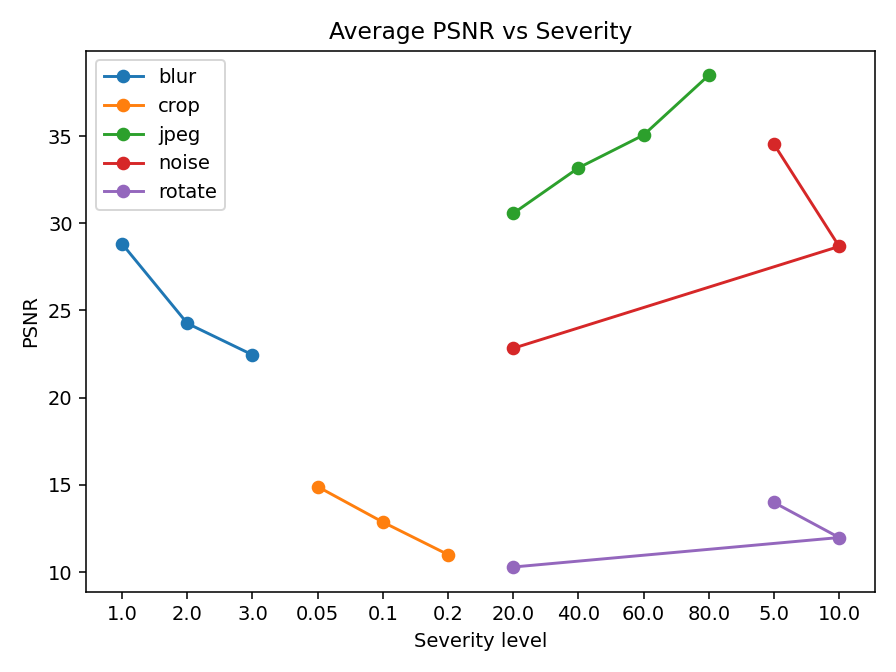

ssim_vs_severity.png exists? True


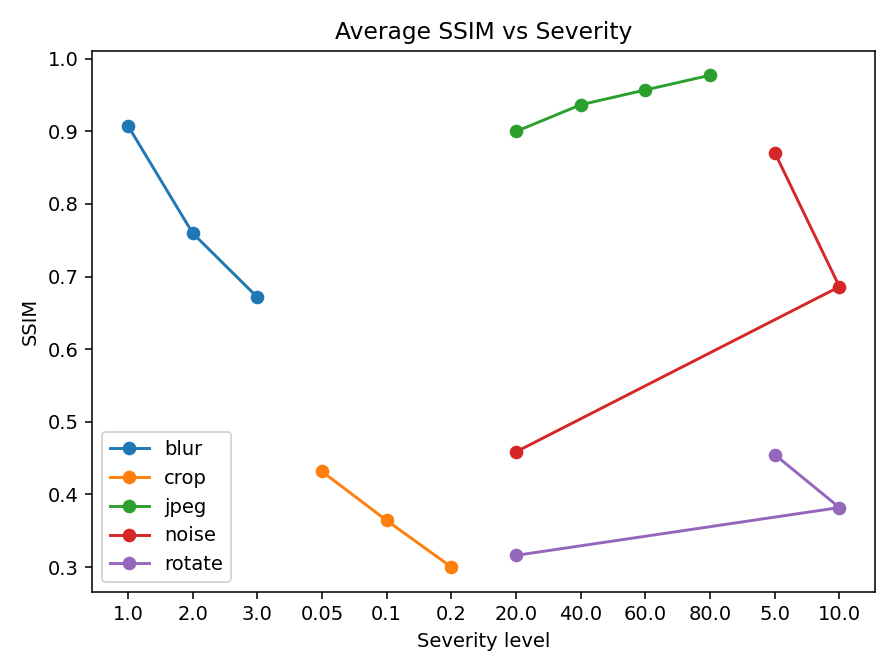

edge_ssim_vs_severity.png exists? True


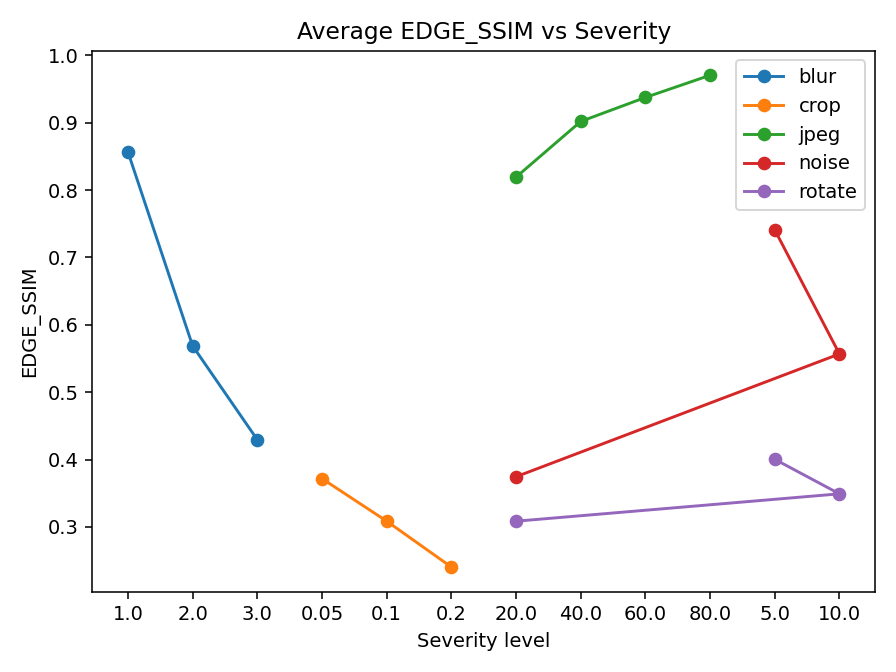

Panels in figures/: 2112


In [8]:
from pathlib import Path
from PIL import Image
from IPython.display import display

OUT = Path("/kaggle/working/results")
print("Root files:", sorted([p.name for p in OUT.iterdir() if p.is_file()]))

for name in ["psnr_vs_severity.png","ssim_vs_severity.png","edge_ssim_vs_severity.png"]:
    fp = OUT / name
    print(name, "exists?", fp.exists())
    if fp.exists():
        display(Image.open(fp))

print("Panels in figures/:", len(list((OUT / "figures").glob("*_panel.png"))))

In [9]:
from pathlib import Path
import pandas as pd

OUT = Path("/kaggle/working/results")
df = pd.read_csv(OUT/"results.csv")
summary = pd.read_csv(OUT/"summary_by_transform.csv")

print("rows:", len(df))
print("unique files:", df["file"].nunique())
print("transforms:", df["transform"].unique())
summary.head(10)

rows: 7744
unique files: 484
transforms: ['jpeg' 'crop' 'rotate' 'noise' 'blur']


,transform,level,psnr,ssim,edge_ssim,mse
0,blur,1.00,28.821247,0.907708,0.856432,128.456553
1,blur,2.00,24.260914,0.759822,0.568715,332.881043
2,blur,3.00,22.454966,0.671586,0.429509,485.277656
3,crop,0.05,14.894670,0.431604,0.371818,2662.159549
4,crop,0.10,12.861896,0.364125,0.308663,4192.439952
5,crop,0.20,10.998334,0.300040,0.240604,6379.127961
6,jpeg,20.00,30.568367,0.899831,0.819124,73.590878
7,jpeg,40.00,33.178275,0.936565,0.901745,41.225010
8,jpeg,60.00,35.063735,0.956989,0.937394,26.521369
9,jpeg,80.00,38.492305,0.977206,0.970317,11.514072


Saved: /kaggle/working/results/figures/top12_worst_ssim_panels.png


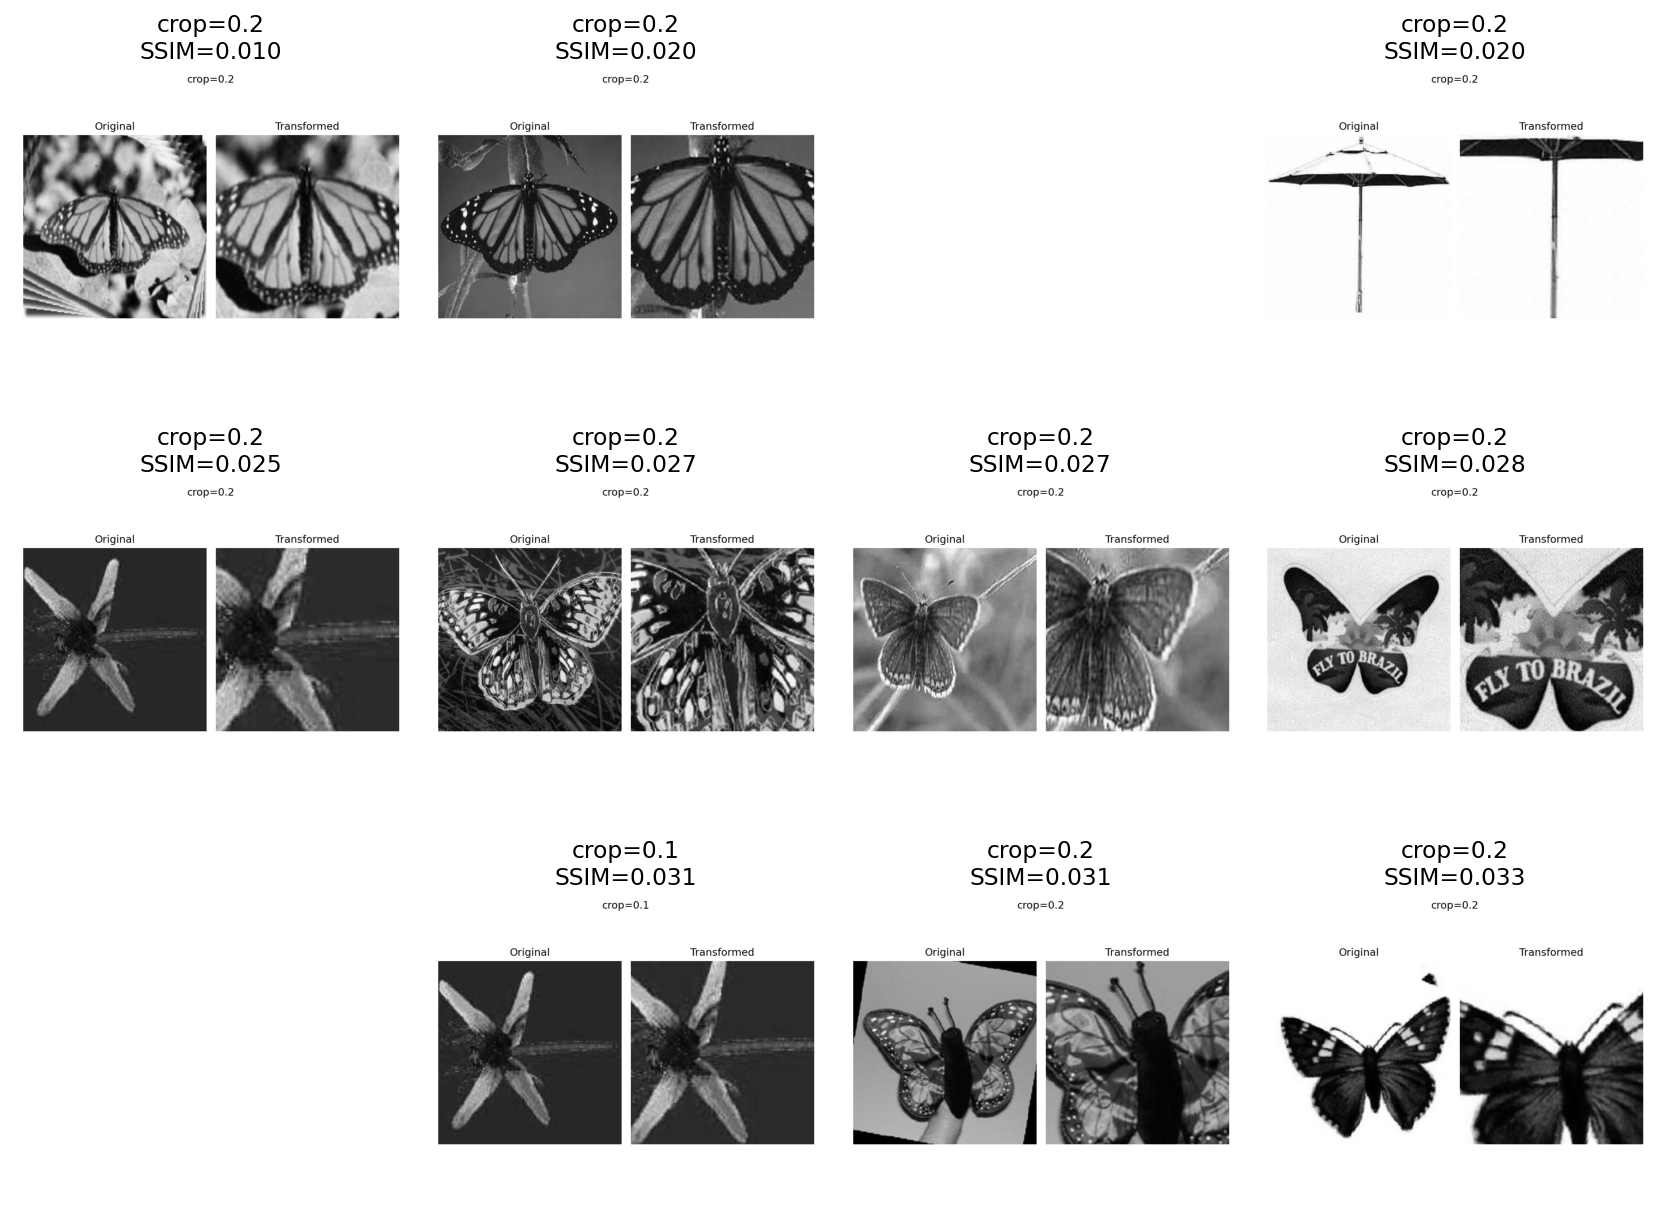

In [10]:
import pandas as pd, numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

OUT = Path("/kaggle/working/results")
df = pd.read_csv(OUT/"results.csv")
worst = df.sort_values("ssim").head(12)

fig = plt.figure(figsize=(12,9), dpi=140)
for i, (_,row) in enumerate(worst.iterrows(), 1):
    p = list((OUT/"figures").glob(Path(row["file"]).stem+f"__{row['transform']}_{row['level']}_panel.png"))
    if not p: 
        continue
    plt.subplot(3,4,i); plt.imshow(Image.open(p[0])); plt.axis("off")
    plt.title(f"{row['transform']}={row['level']}\nSSIM={row['ssim']:.3f}")
fig.tight_layout()
fig.savefig(OUT/"figures/top12_worst_ssim_panels.png")
print("Saved:", OUT/"figures/top12_worst_ssim_panels.png")

In [11]:
def takeaways(summary):
    for t in ["jpeg","crop","rotate","noise","blur"]:
        sub = summary[summary["transform"]==t].sort_values("level", key=lambda s: s.astype(str))
        if sub.empty: continue
        s0, sN = sub["ssim"].iloc[0], sub["ssim"].iloc[-1]
        e0, eN = sub["edge_ssim"].iloc[0], sub["edge_ssim"].iloc[-1]
        p0, pN = sub["psnr"].iloc[0], sub["psnr"].iloc[-1]
        print(f"{t:>6}: ΔPSNR {p0-pN:5.2f} dB | ΔSSIM {s0-sN:.3f} | ΔEdge-SSIM {e0-eN:.3f}")
takeaways(summary)

  jpeg: ΔPSNR -7.92 dB | ΔSSIM -0.077 | ΔEdge-SSIM -0.151
  crop: ΔPSNR  3.90 dB | ΔSSIM 0.132 | ΔEdge-SSIM 0.131
rotate: ΔPSNR -2.01 dB | ΔSSIM -0.073 | ΔEdge-SSIM -0.051
 noise: ΔPSNR -5.86 dB | ΔSSIM -0.185 | ΔEdge-SSIM -0.184
  blur: ΔPSNR  6.37 dB | ΔSSIM 0.236 | ΔEdge-SSIM 0.427
